# Image Compression
Data compression is very important part of our digital world where we have tons of files with huge size. Now we have better and bigger quality data, specially, image. Most of smartphones have better quality camera and the picture taken from those takes more storage too. With more complex pixel combinations, more storage is taken. There are different compression algorithms like JPEG and PNG but my task here is to explain little bit about Lossless Compression using Run Length Encoding. The term lossless means there should not be any loss of data.

## Image 
What is image? Image is a combination of pixels in the digital world. Just like 2d plane, Image also have plane and it only have positive coordinates. I will be using Python to do image operations because it is easy to code on. 

First I will try to compress a dummy image then will go into the real world image and see what can I achieve.

## Preliminary Tasks
* Import Dependencies.
* Define a helper function.

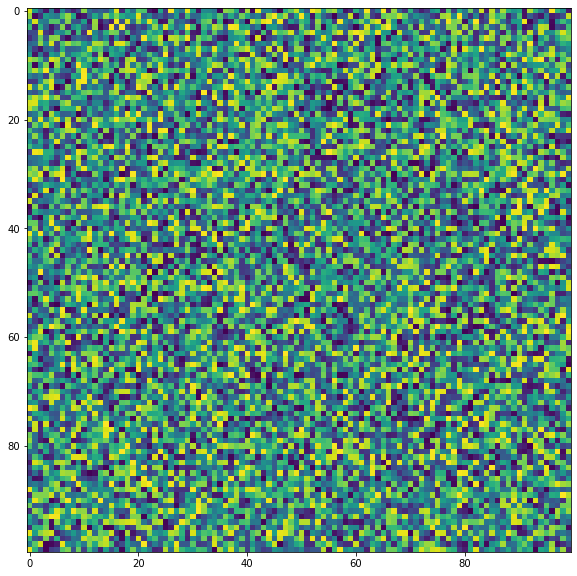

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

def show(img, figsize=(10, 10), title="Image"):
    figure=plt.figure(figsize=figsize)
    
    plt.imshow(img)
    plt.show()

dummy = np.random.randint(0, 255, (100, 100)).astype(np.uint8)
show(dummy)

In above example, I imported libraries like NumPy, Matplotlib, OpenCV, sys and each has own use case.
* NumPy for array operations.
* Matplotlib for simply view our image.
* OpenCV, read and write image.
* Sys for getting array size.

I made a dummy image of shape 100 by 100.

## Some Experiments

In [2]:
# see how much storage is taken by the dummy array
sys.getsizeof(dummy)/1024

9.875

In [3]:
# write a image in jpg
cv2.imwrite("d.png", dummy)

True

In [4]:
# read it back as grayscale
img = cv2.imread("d.png", 0)

In [5]:
# see its size
sys.getsizeof(img)/1024

9.875

**Now check with image which have most storage, a blank or random**

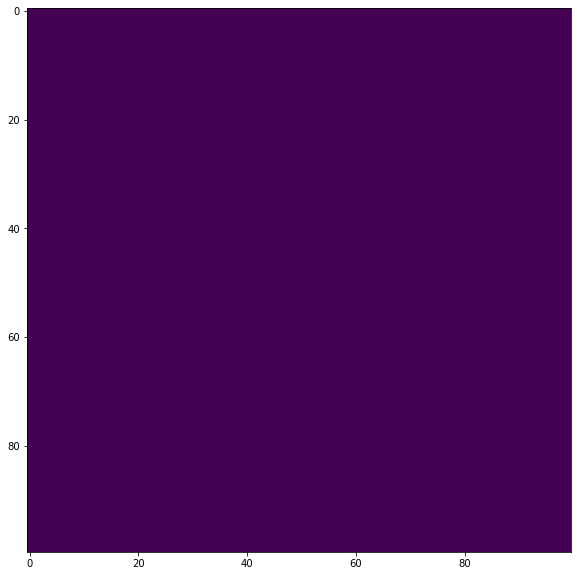

In [6]:
dd = np.zeros((100, 100)).astype(np.uint8)
show(dd)

In [7]:
sys.getsizeof(dd)/1024

9.875

In [8]:
cv2.imwrite("dd.png", dd)

True

It shows that both of these files have same size. But if we see the file created on our folder, then the random image is taking 10.2KB while zero image is taking 214B. Why is that happening? OpenCV is using some compression algorithm to compress as much as possible and it becomes easier to compress an image which have least details or less complex, less varried pixel combination.

Lets find our the size of file from code.

In [9]:
def get_size(filename="dd.png"):
    stat = os.stat(filename)
    size=stat.st_size
    return size

print(get_size())

print(get_size("d.png"))

214
10180


There is huge difference of the size taken by two same sized image. Lets get into the RLE now.

## Run Length Encoding
This is a lossless compression algorithm and it is very simple to practice on. The concept of RLE compression is that check for the consecutive runs of the current pixel value. This algorithm works best on Binary image.

Lets take an example, image `[1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0]` have 16 pixels and it is binary. Now using RLE, we do something like below.
* At the begining, current pointer is first value i.e. `1`. Now compressed image `[11]`. Which means that 1 has repeated 1 times consecutively.
* Next, value is 0. Again it is repeated one times, hence compressed image is `[11 01]`. Which means, 1 is repeated one times then 0 is repeated one times.
* Next, value is 1. Now 1 is repeated three times. Hence compressed image is `[11 01 13]`.
* Similarly, next compressed image is, `[11 01 13 03]`.
* Similarly, final is, `[11 01 13 03 12 01 12 03]`

Our image had 16 values now it is compressed under only 8 values.

Now to decompress it,
* Initial value is 11, which means 1 repeated one times. Image is `[1]`.
* Next value is 01. Similarly, image is `[1 0]`.
* Next value is 13. Similarly, image is `[1 0 1 1 1]`.
* And so on.

### Encode Function
Lets write a function for it. I will be using a below image.
![](bg20.PNG)

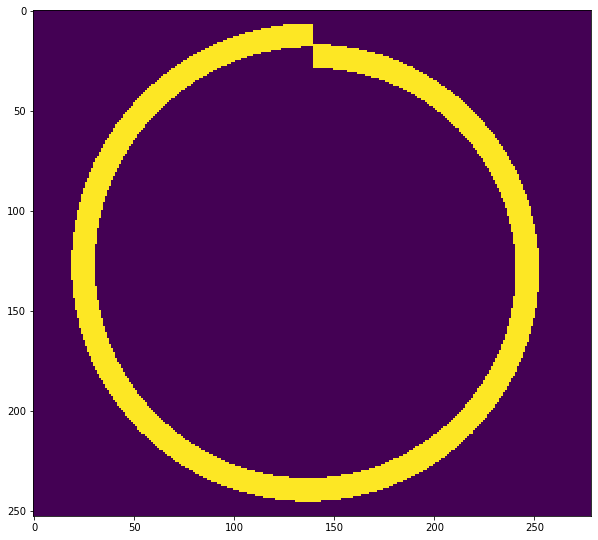

array([[255,   0],
       [255,   0],
       [255,   0],
       ...,
       [255,   0],
       [255,   0],
       [ 48,   0]])

In [165]:
# read graysclae img
def RLE_encoding(img, bits=8,  binary=True, view=True):
    """
    img: Grayscale img.
    bits: what will be the maximum run length? 2^bits       
    """
    if binary:
        ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    if view:
        show(img)

    encoded = []
    shape=img.shape
    count = 0
    prev = None
    fimg = img.flatten()
    th=127
    for pixel in fimg:
        if binary:
            if pixel<th:
                pixel=0
            else:
                pixel=1
        if prev==None:
            prev = pixel
            count+=1
        else:
            if prev!=pixel:
                encoded.append((count, prev))
                prev=pixel
                count=1
            else:
                if count<(2**bits)-1:
                    count+=1
                else:
                    encoded.append((count, prev))
                    prev=pixel
                    count=1
    encoded.append((count, prev))
    
    return np.array(encoded)
fpath="bg20.png"
img = cv2.imread(fpath, 0)
shape=img.shape
encoded = RLE_encoding(img, bits=8)
encoded

I think above code is self explained. But I would describe it anyway.
* Either convert image into Binary or use it as it is.
* Then convert image into flat, i.e 1d vector.
* Now scan from left to right.
* If previous value is same as current then count the run else append `(value, run)` on encoded. And also check the run length, i.e. if it becomes `2**bits - 1` then append it. If it exceeds that value, then our values will be rounded off to 8 bit range later.

### Decode Function

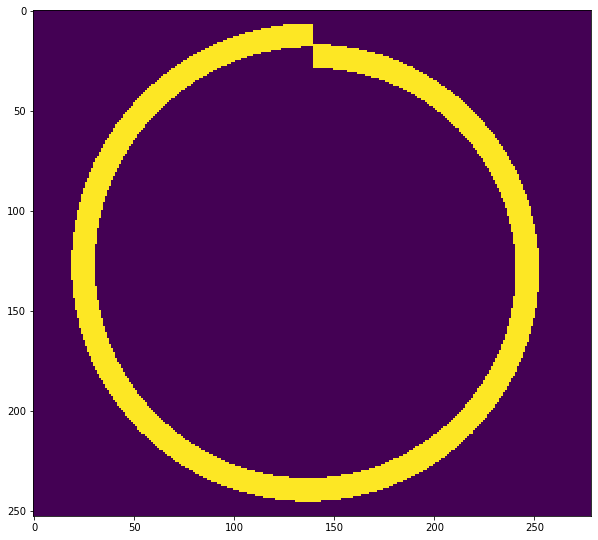

In [123]:
# decode
def RLE_decode(encoded, shape):
    decoded=[]
    for rl in encoded:
        r,p = rl[0], rl[1]
        decoded.extend([p]*r)
    dimg = np.array(decoded).reshape(shape)
    return dimg

dimg = RLE_decode(encoded, shape)
show(dimg)

The decode function is simpler than encoding. Just perform repeation for values by run numbers and reshape it back.

Now save it as `npz`, `npz.npy`, `tif` and `png` format then find out which extension will compress most.

In [124]:
# save the encoded list into npz array file
earr=np.array(encoded)
# earr=earr.astype(np.uint8)
np.savez("np1.npz", earr)
np.save("np2.npz", earr)

In [125]:
# store that array as image
# the earr has shape of (x, 2) which can work fine as an image.
cv2.imwrite("encoded.tif", earr)
cv2.imwrite("encoded.png", earr)

True

Lets see how our encoded array looks like. 

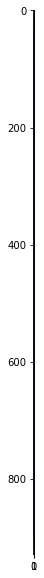

In [126]:
show(earr)

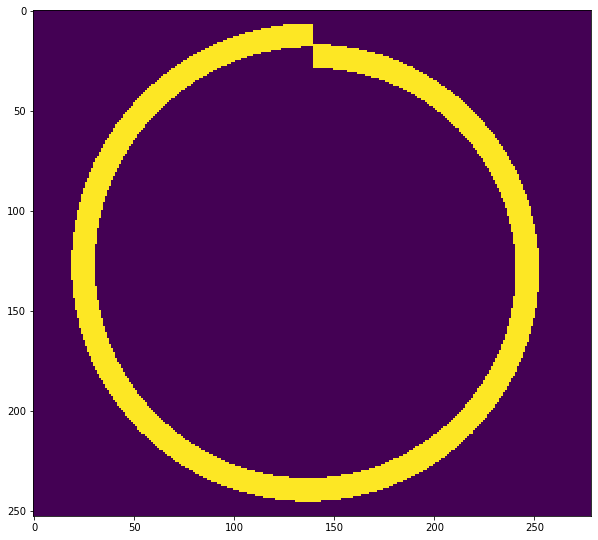

In [127]:
rencd = cv2.imread("encoded.tif", -1)
show(RLE_decode(rencd, shape))

In [128]:
# now check size of each files
files = ["encoded.png", "encoded.tif", "np1.npz", "np2.npz.npy"]
for f in files:
    print(f"File: {f} => Size: {get_size(f)} Bytes")

File: encoded.png => Size: 2088 Bytes
File: encoded.tif => Size: 1532 Bytes
File: np1.npz => Size: 7696 Bytes
File: np2.npz.npy => Size: 7560 Bytes


From above example, it shows that when saving RLE as NumPy compressed, it will take 7696 and 7560 but when saving the encoded array as png image, it takes 2088 Bytes. But using TIFF format, it takes 1532. And also the decoding can be done easily.

Now lets use non binary format of an image.

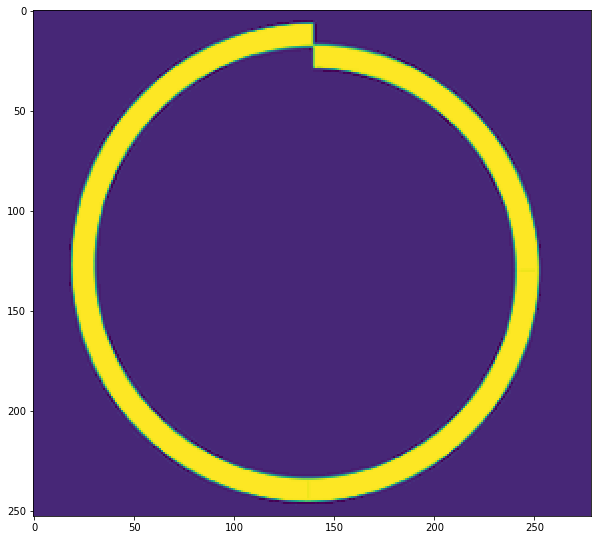

In [129]:
fpath="bg20.png"
img = cv2.imread(fpath, 0)
shape=img.shape
encoded = RLE_encoding(img, bits=8, binary=False)


In [130]:
# save the encoded list into npz array file
earr=np.array(encoded)
# earr=earr.astype(np.uint8)
np.savez("np11.npz", earr)
np.save("np22.npz", earr)

# store that array as image
# the earr has shape of (x, 2) which can work fine as an image.
cv2.imwrite("encoded1.tif", earr)
cv2.imwrite("encoded1.png", earr)



True

In [131]:
# now check size of each files
files = ["encoded1.png", "encoded1.tif", "np11.npz", "np22.npz.npy"]
for f in files:
    print(f"File: {f} => Size: {get_size(f)} Bytes")

File: encoded1.png => Size: 8071 Bytes
File: encoded1.tif => Size: 7098 Bytes
File: np11.npz => Size: 45360 Bytes
File: np22.npz.npy => Size: 45224 Bytes


Now, again the TIFF format wins. Lets see the decoded version.

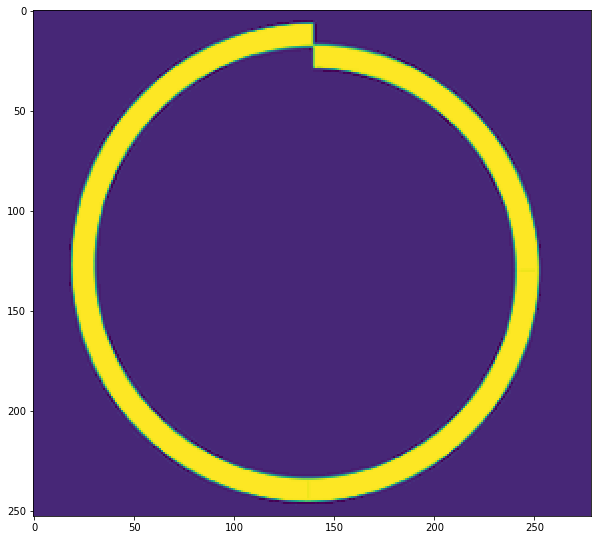

In [132]:
rencd = cv2.imread("encoded1.tif", -1)
show(RLE_decode(rencd, shape))

It is the grayscale version of above image. 

Can I compress RGB Image with this technique? Well that part is yet to be tried.

## RLE on RGB image

I will be using below image.
![](scene.jpg)
The image is 2576 by 1188 and 640KB.

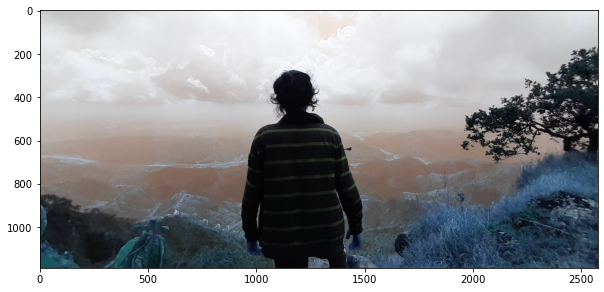

In [144]:
bgr = cv2.imread("scene.jpg", 1)
show(bgr)

It looks little bit weird because Matplotlib expects on RGB format while OpenCV works on BGR.

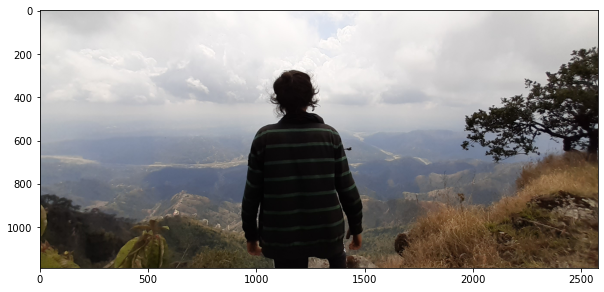

In [145]:
show(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

The idea is to take each channel and treat it as a grayscale image and apply RLE on it. I hope I could compress some percentage of data.

In [146]:
b, g, r = bgr[:, :, 0], bgr[:, :, 1], bgr[:, :, 2]

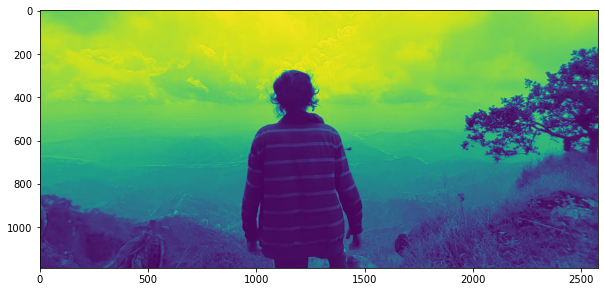

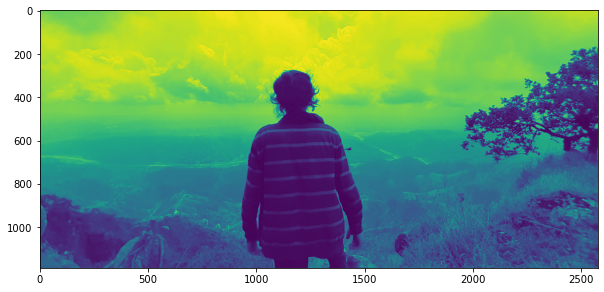

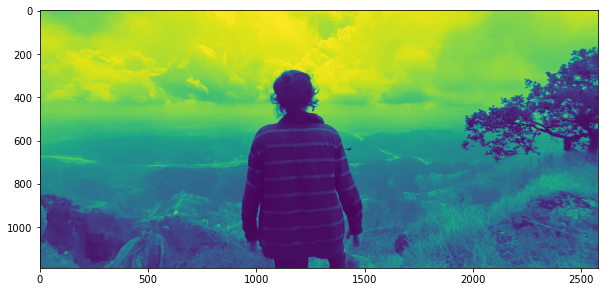

In [152]:
be = RLE_encoding(b, binary=False)
ge = RLE_encoding(g, binary=False)
re = RLE_encoding(r, binary=False)

I have sent each channel but there doesn't seem huge difference on these channels. Lets combine these channels. But I doubt that we can combine these encoded arrays because each channel will have different runs so lets first see each channel's shape.

In [153]:
be.shape, ge.shape, re.shape

((2138548, 2), (2131812, 2), (2137244, 2))

There is no way we could treat these arrays as a channel of an image. What we could do is save each channel on drive.

In [154]:
np.savez("rgbe.npz", [be, ge, re], dtype=object)
get_size("rgbe.npz")

51261839

It took 51MB. Ughh

Lets save individual channels.

In [157]:
np.savez("be.npz", be)
np.savez("ge.npz", ge)
np.savez("re.npz", re)

cv2.imwrite("be.tif", be)
cv2.imwrite("ge.tif", ge)
cv2.imwrite("re.tif", re)


True

In [158]:
files = "bgr"

snp = 0
stif = 0

for f in files:
    ft=f+"e"+".npz"
    snp+=get_size(ft)
    
    ft=f+"e"+".tif"
    stif+=get_size(ft)
    
print(f"Original size: {get_size('scene.jpg')/1024}, TIFF: {stif/1024}, NPZ: {snp/1024}")

Original size: 640.6875, TIFF: 7423.484375, NPZ: 50060.1796875


Original size is 640KB, TIFF size is 7.4MB and NumPy size is 50MB. It is not a good result. So how did it happen? There a re tons of reasons, first of them is that the image is complex and its pixel change is too frequent and there are not much runs. If this is the reason then I will try with the first image.

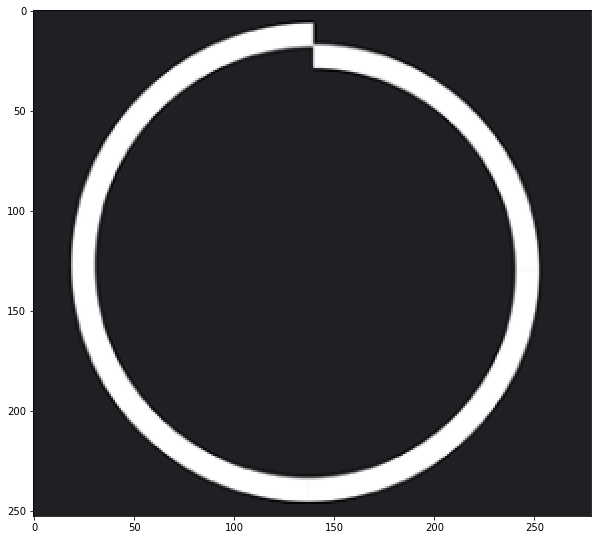

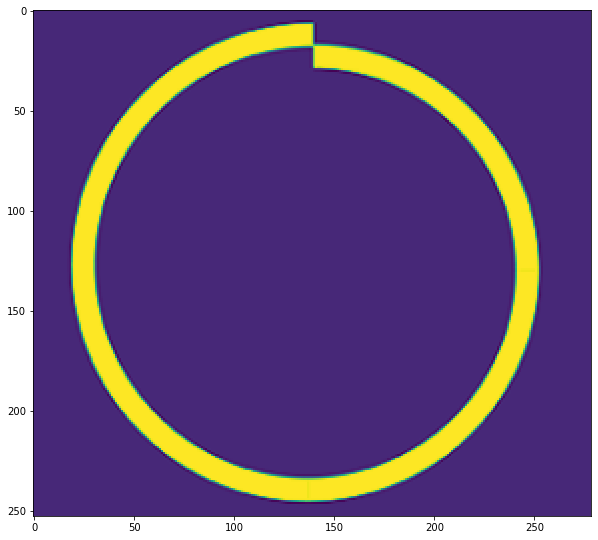

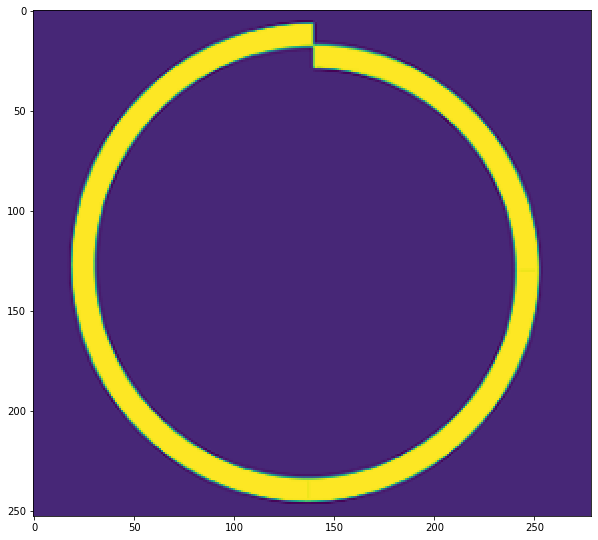

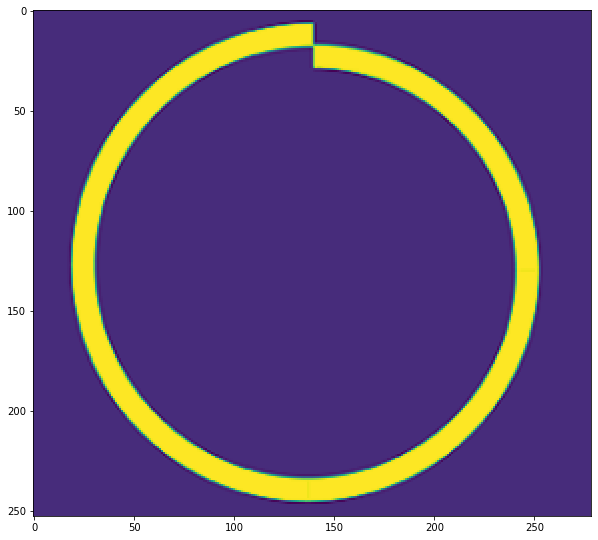

Original size: 16.8671875, TIFF: 25.66015625, NPZ: 150.7421875


In [161]:
bgr = cv2.imread("bg20.png", 1)
show(bgr)

b, g, r = bgr[:, :, 0], bgr[:, :, 1], bgr[:, :, 2]

be = RLE_encoding(b, binary=False)
ge = RLE_encoding(g, binary=False)
re = RLE_encoding(r, binary=False)

np.savez("rgbe1.npz", [be, ge, re], dtype=object)
get_size("rgbe1.npz")

np.savez("be1.npz", be)
np.savez("ge1.npz", ge)
np.savez("re1.npz", re)

cv2.imwrite("be1.tif", be)
cv2.imwrite("ge1.tif", ge)
cv2.imwrite("re1.tif", re)


files = "bgr"

snp = 0
stif = 0

for f in files:
    ft=f+"e"+"1.npz"
    snp+=get_size(ft)
    
    ft=f+"e"+"1.tif"
    stif+=get_size(ft)
    
print(f"Original size: {get_size('bg20.png')/1024}, TIFF: {stif/1024}, NPZ: {snp/1024}")

Again it does not look like we saved any storage. The reason could be we are using unwanted storage. 

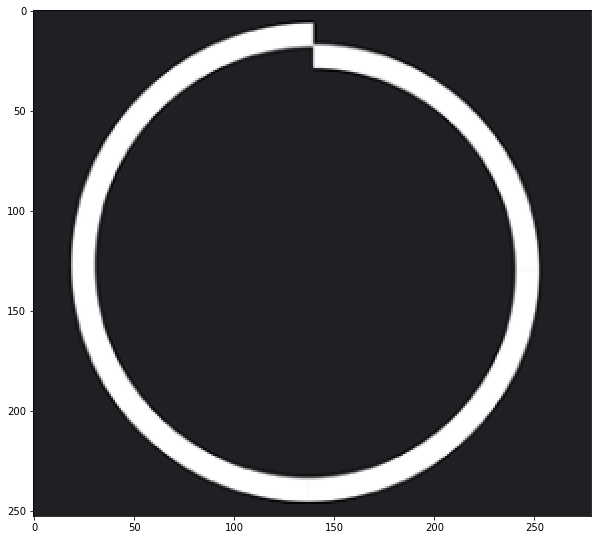

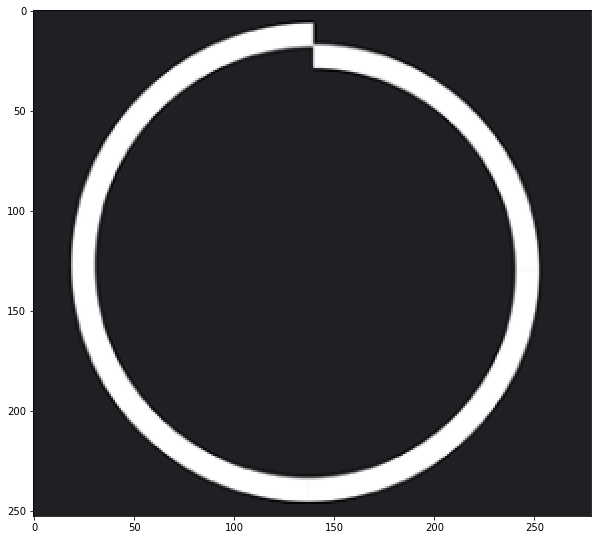

Original Size: 16.8671875 TIFF: 37.23046875


In [169]:
bgr = cv2.imread("bg20.png", 1)
show(bgr)
shape=bgr.shape

encd = RLE_encoding(bgr, binary=False, view=False)

dcd = RLE_decode(encd, shape=shape)
show(dcd)

cv2.imwrite("encd2.tif", encd)

print(f"Original Size: {get_size('bg20.png')/1024} TIFF: {get_size('encd2.tif')/1024}")

It is even worse than the previous attempt.

## Conclusion
This was all an experiment and a little bit of time killing task without any surprising result. But the conclusion from this experiment is that, RLE works great when:
* Image is Binary.
* Image's pixel frequency is not huge.
* Saving on TIFF format.

If you found this blog helpful then I would like to recommend you to support our work via subscribing our YouTube Channel.